In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loss for density prediction
$$
    \mathcal{L} = \sqrt{\frac{1}{N}\sum{(\gamma(x) - \gamma(y))^2}} \\
    \gamma(x) = \underset{1,\ 5}{clip}\left[log_{10}\left(\frac{\phi(x)}{100}\right)\right] \\
    \phi(x) = \begin{cases}
      0.5,\ x \le 1 \\
      \frac{x}{2},\ 1 < x < 20000 \\
      1.125x - 12500,\ 20000 \le x < 100000 \\
      x,\ x \ge 100000
    \end{cases}\,
$$

In [2]:
def phi(x):
    x = np.where(x < 1, 0.5, x)
    x = np.where((1e1 <= x) & (x < 2e4), 0.5 * x, x)
    x = np.where((2e4 <= x) & (x < 1e5), 1.125 * x - 12500, x)
    return x


def gamma(x):
    return np.log10(phi(x) / 100).clip(1, 5)

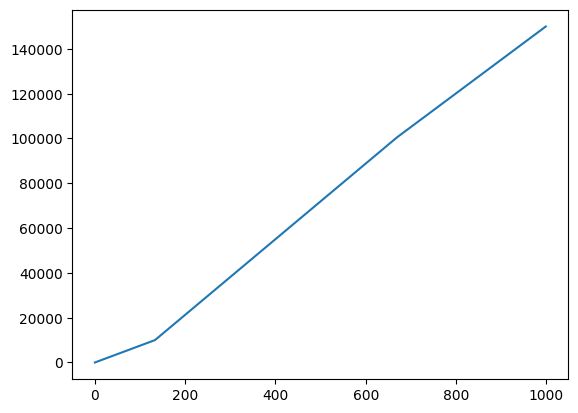

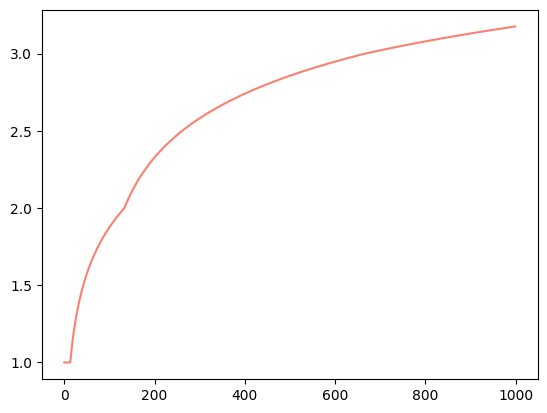

In [9]:
# check the correctness
plt.plot(phi(np.linspace(0, 150_000, num=1000)))
plt.figure()
plt.plot(gamma(np.linspace(0, 150_000, num=1000)), color='salmon');

Note: `gamma` should be implemented in a differentiable fashion for NN training.<br><br>
We should try two hypoteses:
 - Output from NN should be raw density for which we explicitly apply `gamma`, but `y` can be preprocessed with `gamma` in advance.
 - Output from NN should be density which will not be processed, but `y` can be preprocessed with `gamma` in advance.

I would prefer to start with the first hypothesis.

## Weights: normal and adversarial

In [4]:
data_folder_prefix = Path('./data/')

df = pd.read_csv(data_folder_prefix / 'train_labels.csv')
weights = dict(
    df.groupby('region')['uid'].agg('count').astype(float) ** -1
)
w_sum = sum(weights.values())
weights = {k: 4 * v / w_sum for k, v in weights.items()}

In [5]:
weights

{'midwest': 1.0724957262249182,
 'northeast': 2.0642962359534733,
 'south': 0.23718240829260354,
 'west': 0.626025629529005}

In [6]:
submission_df = pd.read_csv(data_folder_prefix / 'submission_format.csv')
weights2 = dict(
    submission_df.groupby('region')['uid'].agg('count').astype(float) ** -1
)
w_sum2 = sum(weights2.values())
weights2 = {k: 4 * v / w_sum2 for k, v in weights2.items()}
adv_weights = {k: v / weights2[k] for k, v in weights.items()}

In [7]:
adv_weights

{'midwest': 1.1223988198303063,
 'northeast': 1.4452933072806708,
 'south': 0.23965374945755658,
 'west': 0.9992676360890754}

In [8]:
9/8

1.125